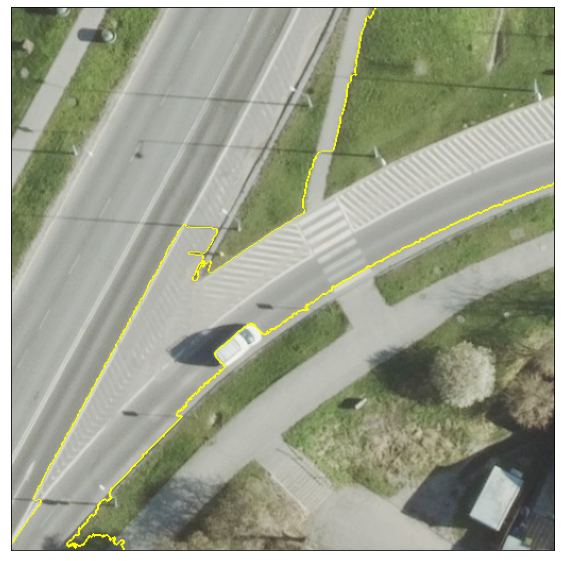

In [2]:
import numpy as np
from skimage import segmentation
from skimage.color import label2rgb
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
import tensorflow as tf

# Load image
image_filepath = '/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/models/custom_data/testing_slic/chelm_city_vertical2_horizontal9.jpg'

image = imread(image_filepath)

# Perform superpixel segmentation
segments = segmentation.slic(image, n_segments=10, compactness=0.1, start_label=0)

superpixel_boundaries = segmentation.mark_boundaries(image, segments, color=(1, 1, 0))

# Create superpixel boundaries overlay
image_segments = array_to_img(superpixel_boundaries)
image_segments.save("/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/models/custom_data/testing_slic/segments.png")
# Display the original image and the superpixel boundaries overlay
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(superpixel_boundaries)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
from src.data.image_postprocessing import ImagePostprocessor, SuperpixelsProcessor
from src.pipelines.prediction_processor import PredictionPipeline
from src.features.utils import get_absolute_path_to_project_location

In [ ]:
slic_params = {
            "n_segments": 200,
            "compactness": 10,
            "max_iter": 10,
            "sigma": 0,
            "spacing": None,
            "multichannel": True,
            "convert2lab": None,
            "enforce_connectivity": True,
            "min_size_factor": 0.5,
            "max_size_factor": 3,
            "slic_zero": False,
            "start_label": 0,
            "mask": None,
        }

In [ ]:
import cv2

In [ ]:
image = cv2.imread("/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/models/custom_data/output/chelm_city_no_post.jpg")


In [ ]:
SuperpixelsProcessor(image, slic_params).postprocess_tiles_borders_in_concatenated_prediction(512, 512, "/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/models/custom_data/output/chelm_border_vertical.jpg")

In [ ]:
concat_img = ImagePostprocessor(
get_absolute_path_to_project_location("models/custom_data/slic_for_bigger_img"),
    get_absolute_path_to_project_location("models/custom_data/out_slic_for_bigger_img"),
).concatenate_images()

In [ ]:
concat_img.shape

In [ ]:
# Load image
image_filepath = get_absolute_path_to_project_location("models/custom_data/out_slic_for_bigger_img/chelm_problematic_sic.jpg")

image = imread(image_filepath)

# Perform superpixel segmentation
n_segments=10000
compactness=5
sigma=1
min_size_factor=1
max_size_factor=5

segments = segmentation.slic(
    image,
    n_segments=n_segments,
    compactness=compactness,
    start_label=0,
    sigma=sigma,
    min_size_factor=min_size_factor,
    max_size_factor=max_size_factor,
)

superpixel_boundaries = segmentation.mark_boundaries(image, segments, color=(1, 0, 0))

# Create superpixel boundaries overlay
image_segments = array_to_img(superpixel_boundaries)
image_segments.save(f"/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/models/custom_data/out_slic_for_bigger_img/segments_min_size_factor{min_size_factor}_max_size_factor{max_size_factor}_sigma{sigma}_n_segments{n_segments}_compactness{compactness}.png")
# Display the original image and the superpixel boundaries overlay
# fig, ax = plt.subplots(figsize=(1000, 10))
# ax.imshow(superpixel_boundaries)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

In [ ]:
model_pred = PredictionPipeline("deeplabv3plus_v5.10.2", get_absolute_path_to_project_location("models/custom_data/output"), get_absolute_path_to_project_location("models/custom_data/output"), "miou")

In [ ]:
not_decoded_prediction = model_pred.get_not_decoded_prediction(image_filepath)

In [ ]:
not_decoded_prediction

In [ ]:
segments = tf.convert_to_tensor(segments)

In [ ]:
segments

In [ ]:
model_pred.image_features.image_width

In [ ]:
segments = tf.reshape(segments, (1, 512, 512))
segments

In [ ]:
not_decoded_prediction

In [ ]:
max_value = tf.reduce_max(segments, keepdims=False, axis=(1, 2))
max_value = max_value.numpy()[0]
max_value

In [ ]:
for segment_num in range(max_value+1):
    indices = tf.where(tf.equal(segments, segment_num))
    print(indices)

In [ ]:
indices = tf.where(tf.equal(segments, 0)).numpy()
extracted_part = tf.gather_nd(not_decoded_prediction, indices)
extracted_part

In [ ]:
# Use tf.math.bincount() to count the occurrences of each value in the tensor

extracted_part = tf.cast(extracted_part, dtype=tf.int32)

counts = tf.math.bincount(extracted_part)

# Find the index of the most often repeated value
most_frequent_value_index = tf.math.argmax(counts)

# Get the most often repeated value
most_frequent_value = most_frequent_value_index.numpy()
most_frequent_value

In [ ]:
# Create a tensor of ones with the shape of indices
ones = tf.ones((tf.shape(indices)[0],), dtype=tf.int64)

# Multiply the ones tensor by max_value
updates = ones * most_frequent_value

# Update the not_decoded_prediction tensor
updated_not_decoded_prediction = tf.tensor_scatter_nd_update(not_decoded_prediction, indices, updates)

In [ ]:
updated_not_decoded_prediction